In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
%config Completer.use_jedi = False

In [6]:
## load data
def data_load(mu):
    """
    Function load data from two point correlation .dat file
    Args:
        mu(int): mumu ,0,1,2
    Returns:
        C_array(np.array): 2d array,C data each line
        t(np.array): 1d time series 
    """ 
    
    file_list = sorted(glob.glob("./s3/mass-0.5689068/*.dat"))  # 根据你的文件名修改通配符

    real_data_all = []  # 用于存储每个文件的一维 real 数组

    for fname in file_list:
        data = np.loadtxt(fname, comments='#')
        
        filtered = data[data[:, 3] == mu]  # 第4列是 mumu
        
        real_values = filtered[:, 5]
        
        real_data_all.append(real_values)

    # 合并成二维数组，每一行是一个文件的数据
    C_array = np.array(real_data_all)
    t = np.array(range(C_array.shape[1]))

    return C_array,t

In [7]:
import glob
data,t = data_load(0)

In [8]:
data.shape

(15, 96)

/tmp/ipykernel_27570/1003800461.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(t,np.log(data[i,:]))


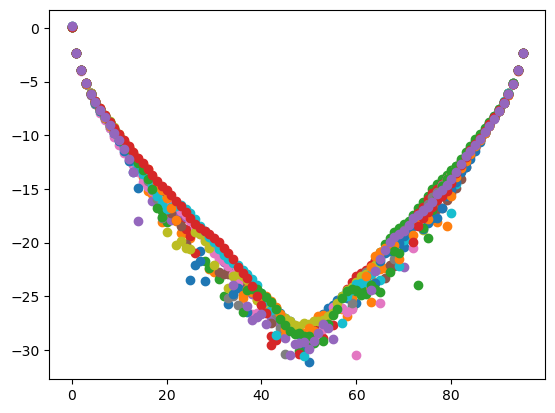

In [12]:
## show raw data
plt.figure()
for i in range(15):
    plt.scatter(t,np.log(data[i,:]))
plt.show()

In [13]:
# as we can see, data closer to the middle is  more dispersed.

In [15]:
# jackknife method
def jackknife_samples(data):
    """
    Compute jackknife samples, mean, and standard error for a 2D array.
    
    Args:
        data (np.ndarray): 2D array of shape (N, T), where N is the number of samples
                          and T is the number of features/time points.
    
    Returns:
        tuple: (jk_samples, mean, error)
            - jk_samples (np.ndarray): Jackknife samples, shape (N, T)
            - mean (np.ndarray): Jackknife mean, shape (T,)
            - error (np.ndarray): Jackknife standard error, shape (T,)
    """
    if not isinstance(data, np.ndarray) or len(data.shape) != 2:
        raise ValueError("Input 'data' must be a 2D NumPy array")
    N, T = data.shape
    if N < 2:
        raise ValueError("At least two samples are required for jackknife")
    
    jk_samples = np.zeros((N, T))
    for i in range(N):
        jk_samples[i] = np.mean(np.delete(data, i, axis=0), axis=0)
    
    mean = np.mean(jk_samples, axis=0)
    error = np.sqrt(N - 1) * np.std(jk_samples, axis=0, ddof=1)
    
    return jk_samples, mean, error

In [16]:
# take the average of two sides
aver_data = (data[:,:48] + np.flip(data[:,-48:]))/2

/tmp/ipykernel_27570/84717791.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(t[:48],np.log(aver_data[i,:]))


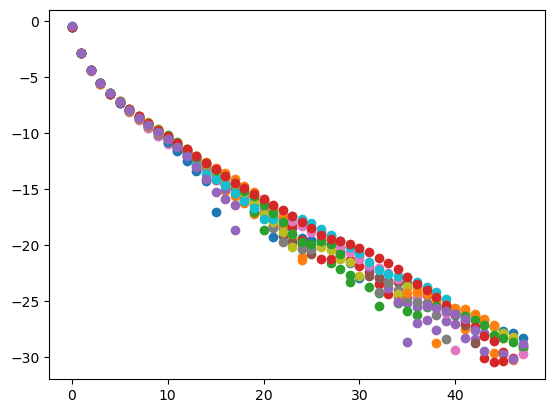

In [122]:
# show average data
plt.figure()
for i in range(15):
    plt.scatter(t[:48],np.log(aver_data[i,:]))
plt.show()

In [21]:
#jackknife process
jk_samples,jk_mean,jk_error = jackknife_samples(aver_data)

In [23]:
t = np.array(range(48))

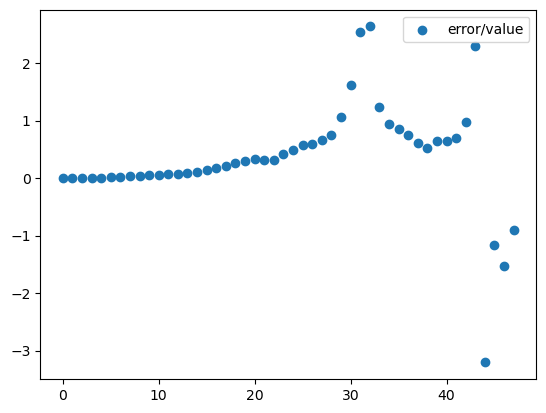

In [36]:
plt.figure()
# plt.scatter(t,jk_mean)
# plt.errorbar(t,jk_mean,jk_error,fmt='o')
plt.scatter(t,jk_error/jk_mean,label='error/value')
plt.legend()
plt.show()

In [44]:
# jackknife method
def jackknife(data,func):
    N,T = data.shape
    jk_samples = np.zeros((N,T-1))
    for i in range(N):
        jk_samples[i] = func(np.mean(np.delete(data,i,axis=0),axis=0))
    mean = np.mean(jk_samples,axis=0)
    error = np.sqrt(N-1)*np.std(jk_samples,axis=0,ddof=1)
    return mean,error

In [46]:
## check the effective mass
def eff_mass(data):
    return np.log(data[:-1]/data[1:])
    
meff_mean,meff_error = jackknife(aver_data,eff_mass)

/tmp/ipykernel_27570/1152174012.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(data[:-1]/data[1:])


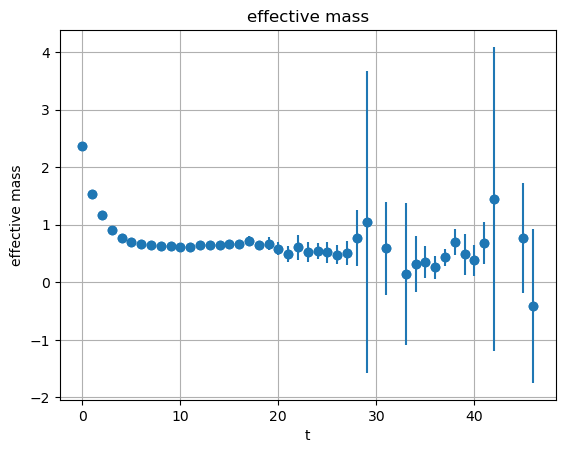

In [48]:
# show the effective mass
plt.figure()
plt.scatter(t[:-1],meff_mean)
plt.errorbar(t[:-1],meff_mean,meff_error,fmt='o')
plt.title("effective mass")
plt.xlabel('t')
plt.ylabel("effective mass")
plt.grid()
plt.show()

 As shown in the figure above, the error of the effective mass becomes larger after point 15.
 Thus we will choose the fit range before 20.

### FIT time

#### One state fit

In [54]:
### fit function
def fit_func_cosh(t,A0,m0,T):
    return A0*np.cosh(m0*(t-T/2))

In [64]:
# fitting 
def fitting(jk_samples,t,t_min,t_max):
    n = jk_samples.shape[0]
    mass = np.zeros(n)
    A0 = np.zeros(n)
    perr = np.zeros(n)

    t_fit = t[(t>=t_min) & (t<=t_max)]

    for i in range(n):
        C_fit = jk_samples[i,t_fit]
        p0 = [C_fit[0],0.5]
        try:
            popt, pcov= curve_fit(lambda t, A0, m0: fit_func_cosh(t, A0, m0,T=48),t_fit,C_fit,p0)
            # popt,_ = curve_fit(fit_func_exp,t_fit,C_fit,p0)
            mass[i] = popt[1]
            A0[i] = popt[0]
            perr[i] = np.sqrt(pcov[1,1])
        except RuntimeError:
            mass[i] = np.nan

    return mass,A0,perr

In [110]:
mass,A0,perr = fitting(jk_samples,t,8,20)

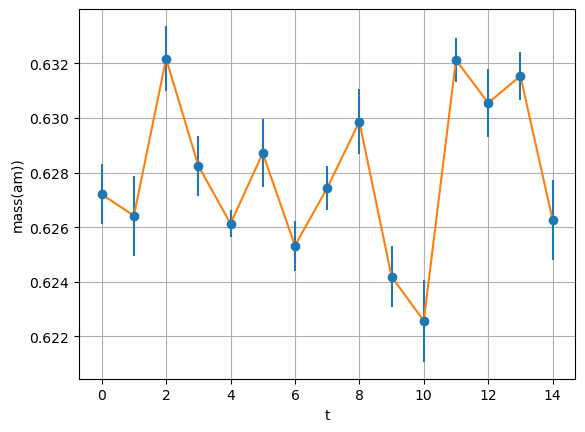

In [111]:
plt.figure()
plt.errorbar(range(15),mass,yerr=perr,fmt='o')
plt.plot(range(15),mass)
plt.xlabel('t')
plt.ylabel('mass(am))')
plt.grid()
plt.show()

In [83]:
##1d jackknife
def jackknife_1d(data):
    N = data.shape[0]
    jk_samples = np.zeros(N)
    for i  in range(N):
        jk_samples[i] = np.mean(np.delete(data,i))
    mean = np.mean(jk_samples)
    error  = np.sqrt(N-1)*np.std(jk_samples,ddof=1)

    return mean,error

In [90]:
#try different t_min
def scan_tmin(tmin_l,tmin_r,t_max,jk_samples,t_vals):
    t_min_list = range(tmin_l,tmin_r)
    mass_values = []
    mass_errors = []

    for t_min in t_min_list:
        mass,A0,_ = fitting(jk_samples,t_vals,t_min,t_max)
        mean,error = jackknife_1d(mass)
        mass_values.append(mean)
        mass_errors.append(error)

    return  np.array(mass_values),np.array(mass_errors),t_min_list

In [91]:
mass_vlaues,mass_errors,t_min_list = scan_tmin(1,15,20,jk_samples,t)

In [105]:
mass_errors

array([0.00021814, 0.00028706, 0.00038895, 0.00057957, 0.00067174,
       0.00073503, 0.00070695, 0.00077743, 0.00104791, 0.00141732,
       0.00159898, 0.00174294, 0.00196799, 0.00263386])

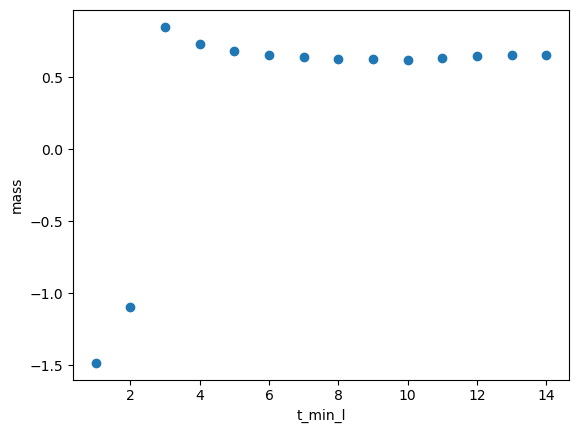

In [106]:
#show the mass
plt.figure()
plt.errorbar(t_min_list,mass_vlaues,mass_errors,fmt='o')
plt.xlabel("t_min_l")
plt.ylabel("mass")
plt.show()

根据上图，当t_min_r取8之后，质量趋于稳定，所以取8作为t_min

In [112]:
mass,A0,perr = fitting(jk_samples,t,8,20)

In [116]:
print(f'mass={mass}')
print(f"A0 ={A0}")
print(f"perr={perr}")

mass=[0.62720282 0.62642022 0.63217147 0.62825285 0.62613032 0.62871006
 0.62532497 0.62742928 0.62986277 0.62419052 0.62256924 0.63212328
 0.63055201 0.6315341  0.62626488]
A0 =[8.41553116e-09 8.56006631e-09 7.67853630e-09 8.29286425e-09
 8.73665614e-09 8.15358922e-09 8.86072457e-09 8.47051412e-09
 7.94036681e-09 8.91968473e-09 9.16353246e-09 7.88740376e-09
 7.94962728e-09 7.81433112e-09 8.57311044e-09]
perr=[0.00110154 0.00146543 0.00119793 0.00110217 0.00049499 0.00124534
 0.00091511 0.00080128 0.00119411 0.00112999 0.00150271 0.00080029
 0.00125417 0.00088363 0.00145019]


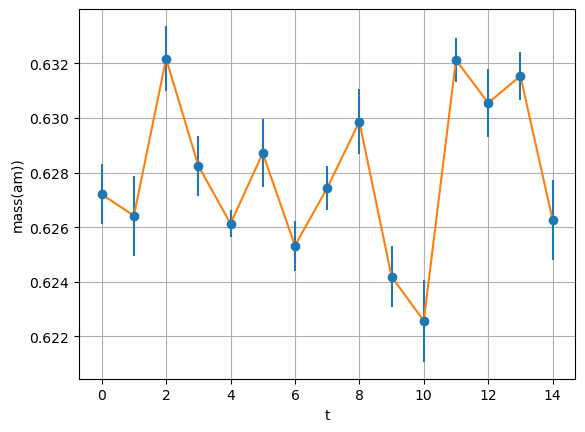

In [113]:
plt.figure()
plt.errorbar(range(15),mass,yerr=perr,fmt='o')
plt.plot(range(15),mass)
plt.xlabel('t')
plt.ylabel('mass(am))')
plt.grid()
plt.show()

In [117]:
mass_mean,mass_error = jackknife_1d(mass)

In [119]:
A0_mean, A0_error = jackknife_1d(A0)

In [118]:
print(f"mass_mean={mass_mean}")
print(f"mass_error={mass_error}")

mass_mean=0.6279159192499625
mass_error=0.0007774285402879156


In [120]:
print(f"A0_mean={A0_mean}")
print(f"A0_error={A0_error}")

A0_mean=8.361102578361686e-09
A0_error=1.20147288449619e-10


### Test  One state fit result

In [121]:
def test_func(t):
    return A0_mean*np.cosh(mass_mean*(t-24))

In [133]:
test_C = test_func(t)

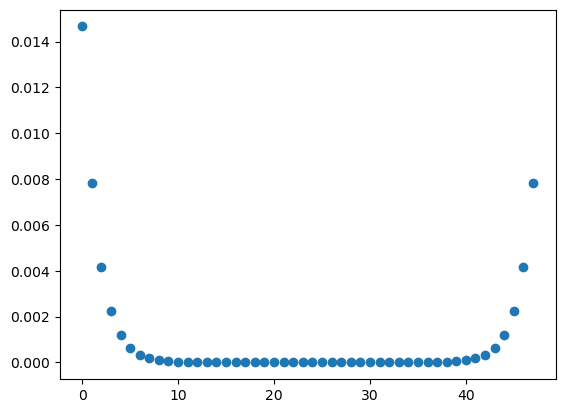

In [139]:
plt.figure()
plt.scatter(t,test_C)
# for i in range(15):
#     plt.scatter(t,aver_data[i,:])
plt.show()

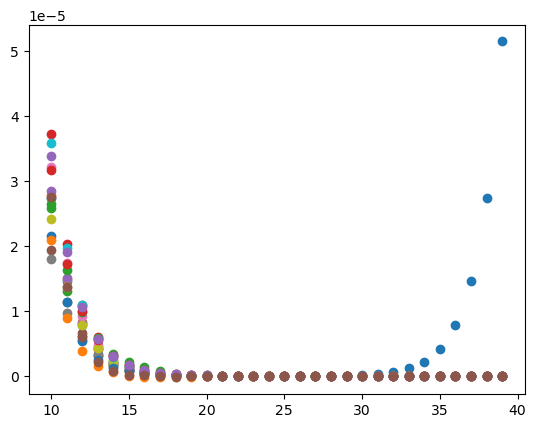

In [140]:
plt.figure()
plt.scatter(t[10:40],test_C[10:40])
for i in range(15):
    plt.scatter(t[10:40],aver_data[i,10:40])
plt.show()

### Two state fit

In [141]:
def two_fit_func(t,A0,m0,A1,m1,T):
    return A0*np.cosh(m0*(48-t))+A1*np.cosh(m1*(48-t))

In [143]:
# fitting 
def two_fitting(jk_samples,t,t_min,t_max):
    n = jk_samples.shape[0]
    m0 = np.zeros(n)
    A0 = np.zeros(n)
    m1 = np.zeros(n)
    A1 = np.zeros(n)
    
    perr_m0 = np.zeros(n)
    perr_m1 = np.zeros(n)

    t_fit = t[(t>=t_min) & (t<=t_max)]

    for i in range(n):
        C_fit = jk_samples[i,t_fit]
        p0 = [C_fit[0],0.5,A0_mean,mass_mean]
        try:
            popt, pcov= curve_fit(lambda t, A0, m0,A1,m1: two_fit_func(t, A0, m0,A1,m1,T=48),t_fit,C_fit,p0)
            # popt,_ = curve_fit(fit_func_exp,t_fit,C_fit,p0)
            m0[i] = popt[1]
            A0[i] = popt[0]
            m1[i] = popt[3]
            A1[i] = popt[2]
            perr_m0[i] = np.sqrt(pcov[1,1])
            perr_m1[i] = np.sqrt(pcov[3,3])
        except RuntimeError:
            m0[i] = np.nan

    return m0,A0,m1,A1,perr_m0,perr_m1

In [144]:
m0,A0,m1,A1,perr_m0,perr_m1 = two_fitting(jk_samples,t,8,20)

/tmp/ipykernel_27570/3065069054.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov= curve_fit(lambda t, A0, m0,A1,m1: two_fit_func(t, A0, m0,A1,m1,T=48),t_fit,C_fit,p0)


array([0.        , 0.        , 0.        , 0.        , 0.62550434,
       0.        , 0.62450208, 0.62669682, 0.        , 0.        ,
       0.        , 0.63057602, 0.        , 0.        , 0.        ])